# Hunter S. Thompson Bot
Since I saw the Harry Potter chapter generated by Botnik Studio, I wanted to see it for Hunter S. Thompson. A few came out, but none from the doctor, so I decided to do it myself. Here I document that project. So far I've collected a bunch of Hunter S. Thompson's books and essays. I just downloaded all the text I could find, often with the incorrect name. I did not clean the text at all, and here are more or less the works I included:

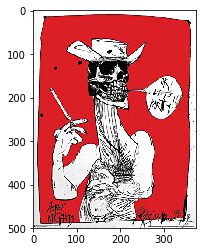

********************************************************************************
Works Included
********************************************************************************
Campaign Trail
Richard Nixon
the great shark hunt

Using TensorFlow backend.



Hells Angels
Fear and Loathing
The Motorcycle Gangs
letter1
Freak Power Rockies
Hollywood
Hippies
Song Sausage Creature
nine eleven
Kentucky Derby
modules loaded...


In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/Users/pablomartin/python/Hunter/Extras/ralph.jpg')
plt.imshow(img)
plt.show()
print '*' * 80
print 'Works Included'
print '*' * 80
for text in os.listdir('/Users/pablomartin/python/Hunter/Input/'):
    tmp = text.replace('_', ' ')
    tmp = tmp[:tmp.find('.')]
    print tmp
    
#BOILERPLATE _______________________
#MODULES ______________________
ROOT = '/Users/pablomartin/python/'
import re

import sys
import pickle
import numpy as np
import pandas as pd
import itertools
import operator
import pysftp


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import np_utils


from RNNmodule.SequenceClass import Sequences
idx = pd.IndexSlice
print 'modules loaded...'

## Preprocessing
First, we concatenate all the works together into one giant file. I'm removing non-ascii characters and making all letters lower case. Then I just chop up all the text into 100 character chunks as my x sample, and the next letter as the corresponding y label. I reshape the data and save it to disk. We went from 2.5MB to ~9GB, yikes.

In [3]:
run_again = 0
if run_again == 1:
    #read file
    raw_text = open(ROOT + 'Hunter/input.txt', 'r').read()
    #everything to lower case
    raw_text = raw_text.lower()
    #remove non-ascii characters
    raw_text = re.sub(r'[^\x00-\x7f]',r'', raw_text)

    # create mapping of unique chars to integers, and a reverse mapping
    chars = sorted(list(set(raw_text)))
    char_to_int = dict((c, i) for i, c in enumerate(chars))
    int_to_char = dict((i, c) for i, c in enumerate(chars))
    # summarize the loaded data
    n_chars = len(raw_text)
    n_vocab = len(chars)
    print "Total Characters: ", n_chars
    print "Total Vocab: ", n_vocab
    # prepare the dataset of input to output pairs encoded as integers
    seq_length = 100
    dataX = []
    dataY = []
    for i in range(0, n_chars - seq_length, 1):
        seq_in = raw_text[i:i + seq_length]
        seq_out = raw_text[i + seq_length]
        dataX.append([char_to_int[char] for char in seq_in])
        dataY.append(char_to_int[seq_out])
    n_patterns = len(dataX)
    print "Total Patterns: ", n_patterns
    # reshape X to be [samples, time steps, features]
    X = np.reshape(dataX, (n_patterns, seq_length, 1))
    # normalize
    X = X / float(n_vocab)
    # one hot encode the output variable
    y = np_utils.to_categorical(dataY)
    print 'saving data...'
    #saving data bulk - this file is ~9GB
    pickle.dump([X,y], open(ROOT + 'Hunter/input_XY.p','wb'))
    #sampling 100 random entries for seeds 
    sub_dataX = [dataX[w] for w in np.random.randint(0,len(dataX),100)]
    pickle.dump(sub_dataX, open(ROOT + 'Hunter/input_as_array.p' , 'wb'))
    pickle.dump(int_to_char, open(ROOT + 'Hunter/int_to_char.p', 'wb'))
    print 'saved data...'



Total Characters:  2552248
Total Vocab:  58
Total Patterns:  2552148
saving data...
saved data...


## Training Model
Once the data was prepared, running the model is "simple" enough. We are going to use an LSTM network with 2 layers, and 256 units in each layer. We will introduce dropout of 20% after each layer, and a last layer of size of our vocabulary with a softmax activation (standard). We are using a fairly 'large' mini-batch size of 512 so that it trains faster and for the gradients to be smoother. We include some checkpoints so we save the model every time there's been an improvement. Tensorflow by default selects a GPU if it's been configured properly so it's very straightforward to train. What was difficult was setting up the GPU, which was 2 days of Linux hell. We are using an Nvidia Tesla K40c GPU. The training code looked something like this:

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath= ROOT + 'Hunter/models256/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
# fit the model
model.fit(X, y, epochs=100, batch_size=512, callbacks=callbacks_list)

### Downloading Files
We are using the awesome pysftp library to check what the best model on epsilon is and download it. Then we run it to get the output 

In [2]:
#download a better model if it exists
srv = pysftp.Connection(host = "10.81.104.156", username = "pablo", password = "pablo2014")
models_available = srv.listdir('/home/pablo/python/Hunter/models/')
model_loss = [float(str((w[w.find('.')-1:-5]))) for w in models_available]
best_model = models_available[np.argmin(model_loss)]
if not os.path.isfile(ROOT + 'Hunter/models256/' + best_model):
    print 'downloading %s ...' %best_model
    srv.get('/home/pablo/python/Hunter/models/' + best_model,
            '/Users/pablomartin/python/Hunter/models256/' + best_model)
else:
    print 'best model already downloaded...'

    
# load the LSTM model
model_config = pickle.load(open(ROOT + 'Hunter/Extras/network_config256.p', 'rb'))
model = Sequential.from_config(model_config)
n_vocab = model.output.shape[1].value

#load best model if it exists and start from there
if os.listdir(ROOT + 'Hunter/models256/'):
    #finding epoch number
    dashes = [w.start() for w in re.finditer(r"-", best_model)]
    initial_epoch = int(best_model[dashes[1] + 1: dashes[2]])
    print 'best model so far: %s, epoch: %i/100' %(best_model, initial_epoch)
    model.load_weights(ROOT + 'Hunter/models256/' + best_model)
else:
    print 'no model has been trained yet!'
    


#load number to character mapping
int_to_char = pickle.load(open(ROOT + 'Hunter/Extras/int_to_char.p', 'rb'))
    
# pick a random seed
seeds = pickle.load(open(ROOT + 'Hunter/Extras/seeds.p', 'rb'))
start = np.random.randint(0, len(seeds)-1)
pattern = seeds[start]


print '\n' + '*' * 80
print 'GENERATED OUTPUT'
print '*' * 80 + '\n'
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    
    by_max = np.argmax(prediction)
    by_probability = int(np.digitize(np.random.random(), np.cumsum(prediction)))
    options = [by_max, by_probability]
    index = options[np.random.random() > 0.4]
    
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print "\n\n" + '*' * 80



best model already downloaded...
best model so far: weights-improvement-84-1.4750.hdf5, epoch: 84/100

********************************************************************************
GENERATED OUTPUT
********************************************************************************

lbylk a big notorious concetned around in the seizeo and the seoate tno truth in good status astociated to in a serious gang of both forc. they were aaout to be stfll sorkger and the lean of the stcater erilcd, change hisling when the stopd was this thing top that the mysteries were stdady a co. . . he was the governor thursday afp this doubt it would selze the goe and public abross that time so heavy was a naria
white fvil cops and time to keep this cosner for one of the truck was are motel to be a bett or three weeks in the side of the new south,
kisning hvmphrey stgll waltin. iis at that pigce of the real political experience of the press people on. the the one that any contoll the seemed doet the stiat o

### Conclusions - for now

It's really fun to watch the model gradually improve. The model definitely learned to spell english words for the most part and we can see some of Hunter's favorite words come up: republican, street, hells angels, oakland, san fransisco, party, etc. 

The loss looks like it was asymptoting a while ago, but output 'seemed' to be getting better. We trained the model for 84 epochs, and it took like 3-4 days. This was a good start, but we must be getting back to my real work (grad school). We can revisit this project in the future and maybe try the following:

1) preprocessing will be by sentences, not random 100 character lengths. we will pad/truncate where appropriate  
2) we will split our data into training and validation sets and track the loss/accuracy of both over epochs ! not sure why we didn't do this this time around ...    
3) I'm hesitating on whether to increase the size of the network in case it doesn't fit well in memory ? Will have to research how to determine that. We have a 2 layer network with 256 cells per layer, which seems big to me already but people out there are doing even bigger networks.  
4) maybe we will check original texts and clean up some of it manually... maybe  

This was written on August 3rd, 2018.

## Round 2 !